In [1]:
# Homework 3 Author: Heeirthan Shanthan Date: 09/29/23

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('/Users/heeir/Downloads/housing.csv')

In [4]:
# let's model median_house_value as our target variable
# I'll pick these six features
# I don't think lat and long will be useful for a linear model,
# and I will omit the string column ocean_proximity
features = ['housing_median_age', 'total_rooms','total_bedrooms',
            'population', 'households', 'median_income']
target = ['median_house_value']

In [5]:
# drop columns we won't use
df = df[features+target]

In [6]:
# drop rows with missing data in one of the remaining columns
df = df.dropna()

In [7]:
# let's do a train-val-test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df[features],
                                                 df[target],
                                                 test_size = 0.4,
                                                 random_state = 0)

In [8]:
x_val,x_test,y_val,y_test = train_test_split(x_test,
                                             y_test,
                                             test_size = 0.5,
                                             random_state = 0)

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lr = LinearRegression()

In [11]:
lr.fit(x_train,y_train)
lr.score(x_val,y_val)

0.5614677159523239

In [12]:
import matplotlib.pyplot as plt
from itertools import combinations

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA(n_components=6) # controls how many principal components are returned
# this gives us an object we can fit to some data

In [15]:
pca.fit(x_train)

PCA(n_components=6)

In [16]:
# let's normalize the data first
from sklearn import preprocessing

In [17]:
scaler = preprocessing.StandardScaler()

In [18]:
# I fit the scaler to my training data
scaler.fit(x_train)

StandardScaler()

In [19]:
x_train_sc = scaler.transform(x_train)

In [20]:
# fits the PCA to the scaled data
pca = PCA()
pca.fit(x_train_sc)

PCA()

In [21]:

# PC transforming and scaling training and validation data 
# Fitting validation and training x-data to dataframe
pca_features = ['pc'+str(i) for i in range(1,7)]
df_pca = pd.DataFrame(pca.transform(x_train_sc),columns = pca_features)
x_train_pca = pd.DataFrame(pca.transform(x_train_sc),columns = pca_features)
x_val_sc = scaler.transform(x_val)
x_val_pca = pd.DataFrame(pca.transform(x_val_sc),columns = pca_features)

In [22]:
# list comp which creates a deep copy
# This is for original feature set:
fs = [feat for feat in features]
important_features = []
# train linear models on each subset of 5 from fs, and remove from fs the least important.
while len(fs)>0:
    if len(fs)==1:
        important_features.insert(0,fs[0])
        break
    res = []
    for comb in combinations(fs,len(fs)-1):
        missing = [_ for _ in fs if _ not in list(comb)][0]
        comb = list(comb)
        lr.fit(x_train[comb],y_train)
        score = lr.score(x_val[comb],y_val)
        res.append((missing,score))
    least_important = max(res,key = lambda t:t[1])[0]
    important_features.insert(0,least_important)
    fs.remove(least_important)
    

#print features from most to least important:
print(important_features)

['median_income', 'housing_median_age', 'households', 'population', 'total_rooms', 'total_bedrooms']


In [23]:
# now, check accuracy of our model with the first most predictive feature, the first two, ...
# appending this to list
acc = []
for i in range(1,len(important_features)+1):
    lr.fit(x_train[important_features[:i]],y_train)
    acc.append(lr.score(x_val[important_features[:i]],y_val))

In [24]:
#1. Run feature selection by elimination on the principle components the same way we did on the original feature set.
#Compute the accuracies on the validation set using the most predictive n features, as n = 1, ..., 6.
#Plot these accuracies vs the accuracies we got by doing elimination on the original feature set.
#Is the set of n most predictive principal components more predictive than the set of n most predictive original features?

In [25]:
# list comp which creates a deep copy
# This is for pca feature set:
fs1 = [feat for feat in pca_features]
print(fs1)
pcaimp_features= []

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']


In [26]:
# train linear models on each subset of 5 from fs1, and remove from fs1 the least important.
while len(fs1)>0:
    if len(fs1)==1:
        pcaimp_features.insert(0,fs1[0])
        break
    res1 = []
    for comb in combinations(fs1,len(fs1)-1):
        missing = [_ for _ in fs1 if _ not in list(comb)][0]
        comb = list(comb)
        lr.fit(x_train_pca[comb],y_train)
        score = lr.score(x_val_pca[comb],y_val)
        res1.append((missing,score))
    least_important = max(res1,key = lambda t:t[1])[0]
    pcaimp_features.insert(0,least_important)
    fs1.remove(least_important)

#print most predictive principal components
print(pcaimp_features)

['pc2', 'pc3', 'pc5', 'pc4', 'pc1', 'pc6']


In [27]:
# checking PC accuracy of our model with the first of the most important pc, the first two, ...
# then appending scores in list
pcacc = []
for i in range(1,len(pcaimp_features)+1):
    lr.fit(x_train_pca[pcaimp_features[:i]],y_train)
    pcacc.append(lr.score(x_val_pca[pcaimp_features[:i]],y_val))

pcacc

[0.2933220213824711,
 0.49464544219376727,
 0.5323471711320591,
 0.5560358369251055,
 0.5615219099178586,
 0.5614677159523239]

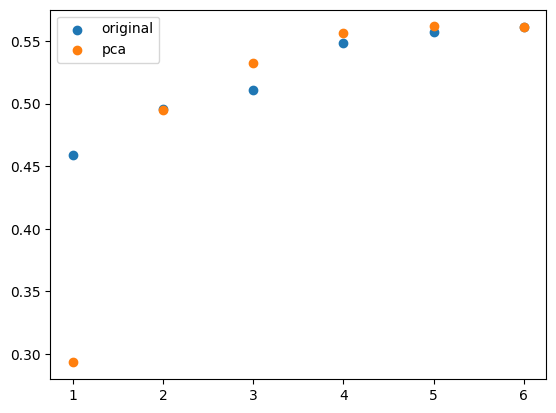

In [28]:
#plotting validation set accuracies from n most predictive features vs accuracies from 
# n most predictive PCs
fig,ax = plt.subplots()
ax.scatter(range(1,len(important_features)+1),acc, label = 'original');
ax.scatter(range(1,len(pcaimp_features)+1),pcacc, label = 'pca');
ax.legend();


In [29]:
# I would argue that the set of n most predictive PCs are more accurate compared to the set of n most 
# predictable original features, given that more than one principal component is used.

In [30]:
#2 Do feature elimination on the original set of six features using a selection of regression models:

In [31]:
# Lasso selection

In [32]:
from sklearn.linear_model import Lasso
ls = Lasso()

In [33]:
fslasso = [feat for feat in features]
importantlasso_features = []
# train linear models on each subset of 5 from fs, and remove from fs the least important.
while len(fslasso)>0:
    if len(fslasso)==1:
        importantlasso_features.insert(0,fslasso[0])
        break
    res = []
    for comb in combinations(fslasso,len(fslasso)-1):
        missing = [_ for _ in fslasso if _ not in list(comb)][0]
        comb = list(comb)
        ls.fit(x_train[comb],y_train)
        score = ls.score(x_val[comb],y_val)
        res.append((missing,score))
    least_important = max(res,key = lambda t:t[1])[0]
    importantlasso_features.insert(0,least_important)
    fslasso.remove(least_important)

#Using Lasso selection, the feature importance list is printed from most to least important:
#No change in feature importance from Linear Regression
print("Lasso Selection Model: " ,importantlasso_features)    


Lasso Selection Model:  ['median_income', 'housing_median_age', 'households', 'population', 'total_rooms', 'total_bedrooms']


In [34]:
# Ridge Selection

In [35]:
from sklearn.linear_model import Ridge
ri = Ridge()

In [36]:
fsridge = [feat for feat in features]
importantridge_features = []
# train linear models on each subset of 5 from fs, and remove from fs the least important.
while len(fsridge)>0:
    if len(fsridge)==1:
        importantridge_features.insert(0,fsridge[0])
        break
    res = []
    for comb in combinations(fsridge,len(fsridge)-1):
        missing = [_ for _ in fsridge if _ not in list(comb)][0]
        comb = list(comb)
        ri.fit(x_train[comb],y_train)
        score = ri.score(x_val[comb],y_val)
        res.append((missing,score))
    least_important = max(res,key = lambda t:t[1])[0]
    importantridge_features.insert(0,least_important)
    fsridge.remove(least_important)

#Using Lasso selection, the feature importance list is printed from most to least important:
#No change in feature importance from Linear Regression and Lasso Selection
print("Ridge Selection Model: " ,importantridge_features)  

Ridge Selection Model:  ['median_income', 'housing_median_age', 'households', 'population', 'total_rooms', 'total_bedrooms']


In [37]:
from sklearn.linear_model import ElasticNet
el = ElasticNet()

In [38]:
fselnet = [feat for feat in features]
importantelnet_features = []
# train linear models on each subset of 5 from fs, and remove from fs the least important.
while len(fselnet)>0:
    if len(fselnet)==1:
        importantelnet_features.insert(0,fselnet[0])
        break
    res = []
    for comb in combinations(fselnet,len(fselnet)-1):
        missing = [_ for _ in fselnet if _ not in list(comb)][0]
        comb = list(comb)
        el.fit(x_train[comb],y_train)
        score = el.score(x_val[comb],y_val)
        res.append((missing,score))
    least_important = max(res,key = lambda t:t[1])[0]
    importantelnet_features.insert(0,least_important)
    fselnet.remove(least_important)

#Using Elastic-Net selection, the feature importance list is printed from most to least important:
#No change in feature importance from Linear Regression , Ridge and Lasso Selection
print("Elastic-Net Model: " ,importantelnet_features) 

Elastic-Net Model:  ['median_income', 'housing_median_age', 'households', 'population', 'total_rooms', 'total_bedrooms']


In [39]:
#References:
# Lecture Notes
# scikit-learn.org/stable/modules/linear_model.html
